In [30]:
# import packages
from os import chdir, listdir
import pickle
import matplotlib.pyplot as plt
import copy

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision import transforms as T

from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

In [8]:

# load dataset
data_dict = pickle.load(open('obj_dict.dat', 'rb'))

dataset = data_dict['added_filter_20_dataset_chw']
dataset = dataset['data']
print(dataset[0])

{'face': array([[[ 67,  70,  74, ..., 130, 131, 132],
        [ 67,  70,  74, ..., 128, 128, 128],
        [ 67,  70,  74, ..., 126, 123, 121],
        ...,
        [ 76,  72,  65, ...,  93,  98, 101],
        [ 78,  74,  67, ...,  94, 101, 105],
        [ 79,  75,  69, ...,  94, 103, 108]],

       [[ 67,  68,  70, ..., 114, 116, 117],
        [ 67,  68,  70, ..., 113, 113, 114],
        [ 68,  69,  71, ..., 110, 110, 109],
        ...,
        [ 49,  47,  43, ...,  51,  57,  60],
        [ 47,  45,  43, ...,  46,  53,  57],
        [ 46,  45,  43, ...,  43,  51,  56]],

       [[ 75,  75,  77, ..., 115, 118, 120],
        [ 74,  75,  77, ..., 114, 116, 117],
        [ 73,  75,  78, ..., 111, 111, 111],
        ...,
        [ 54,  52,  48, ...,  65,  71,  74],
        [ 53,  52,  49, ...,  61,  68,  72],
        [ 53,  51,  49, ...,  58,  66,  71]]], dtype=uint8), 'label': 'without_mask'}


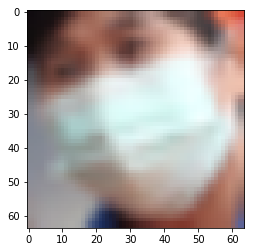

In [12]:
# A sample img in the dataset
plt.imshow(np.transpose(dataset[20]['face'],(1,2,0)));

In [13]:
# Construct the custom dataset class
class MyDataset(Dataset):
    def __init__(self, dataset,transform):
        self.dataset = dataset
        self.transform = transform
        self.label_dict = {'without_mask':0,'with_mask':1,'mask_weared_incorrect':2}
    
    def __getitem__(self, index):
        img = self.dataset[index]['face']
        label = self.label_dict[self.dataset[index]['label']]
        img = torch.as_tensor(img, dtype=torch.float32)
        #Normalize pixel values to numbers between 0 and 1
        img = img/255
        label = torch.tensor(label)
        if self.transform:
          img = self.transform(img)

        return img, label
    
    def __len__(self):
        return len(self.dataset)

In [14]:
face_dataset = MyDataset(dataset,transform = None)
dataset_size = len(dataset)

# Split dataset into training set, validation set, and test set
train_size = int(dataset_size * 0.6)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(face_dataset, [train_size, val_size, test_size])

In [15]:
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [16]:
# Build a simple CNN 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)    # input 3 channel, because rgb image. 20 filters, 5x5 size
        self.conv2 = nn.Conv2d(20, 50, 5, 1)   # input 20 channel, previous layer has 20 filters. 50 filters, 5x5 size
        self.fc1 = nn.Linear(13*13*50, 500)      # 13*13*50 --> 500 linear layer
        self.fc2 = nn.Linear(500, 3)          # 500 --> 3 linear layer

    def forward(self, x):  
        x = F.relu(self.conv1(x)) 
        x = F.max_pool2d(x, 2, 2) 
        x = F.relu(self.conv2(x)) 
        x = F.max_pool2d(x, 2, 2) 
        x = x.view(-1, 13*13*50)   
        x = F.relu(self.fc1(x))   
        x = self.fc2(x)           
        return F.log_softmax(x, dim=1)  

In [26]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    train_loss = 0
    model.train() 
    for batch_idx, (img, label) in enumerate(train_loader):   
        
        img, label = img.to(device), label.to(device)     # use gpu if possible
        optimizer.zero_grad()                                 # clean gradients
        output = model(img)
        loss = criterion(output, label)                      # what is loss
        train_loss += loss.item()* len(img)

        loss.backward()                                       # calculate loss
        optimizer.step()                                      # update weights (update filters in this case)
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(img), 
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()
            ))
    train_loss /=len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(
        train_loss))
    return train_loss


In [27]:
def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for img, label in val_loader:
            img, label = img.to(device), label.to(device)
            output = model(img) 
            loss = criterion(output, label)  
            val_loss += loss.item()*len(img)
                       
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            

            correct += pred.eq(label.view_as(pred)).sum().item()


    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)

    print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), accuracy
        ))
    return val_loss, accuracy

In [20]:
# This is a function to get all the predictions in the test set.
def get_all_preds(model, loader,device):
    all_preds = torch.tensor([])
    targets =torch.tensor([])
    with torch.no_grad():
        for batch in loader:
            img, label = batch
            img, label = img.to(device), label.to(device)
            preds = torch.Tensor.cpu(model(img))
            all_preds = torch.cat(
                (all_preds, preds)
                ,dim=0
            )
            targets = torch.cat((targets,torch.Tensor.cpu(label)),dim = 0)
    return all_preds, targets.int()

In [21]:
# function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
use_cuda = torch.cuda.is_available()  
device = torch.device("cuda" if use_cuda else "cpu")  
print(device)

lr = 0.01

# Use pretrained Resnet50 for transfer learning
# Load pretrained model and modify the last layer for 3-class classification
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Use a CNN
# model = Net()

# # move model to the right device
model.to(device)
# define optimizer
optimizer = optim.SGD(model.parameters(), lr=lr,momentum = 0) 
# Define Loss function
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

cpu


In [45]:
# train the model
epochs =10
train_losses = []
val_losses = []
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)

    val_loss, val_accuracy =val(model, device, val_loader)
    val_losses.append(val_loss)
    if val_accuracy > best_acc:
        best_model_wts = copy.deepcopy(model.state_dict())
    scheduler.step()



Train Epoch: 1 [0/1366 (0.000000%)]	Loss: 0.945790
Train Epoch: 1 [160/1366 (11.627907%)]	Loss: 0.529154
Train Epoch: 1 [320/1366 (23.255814%)]	Loss: 0.518327
Train Epoch: 1 [480/1366 (34.883721%)]	Loss: 0.393908
Train Epoch: 1 [640/1366 (46.511628%)]	Loss: 0.294470
Train Epoch: 1 [800/1366 (58.139535%)]	Loss: 0.215698
Train Epoch: 1 [960/1366 (69.767442%)]	Loss: 0.415538
Train Epoch: 1 [1120/1366 (81.395349%)]	Loss: 0.131725
Train Epoch: 1 [1280/1366 (93.023256%)]	Loss: 0.399244
Train set: Average loss: 0.0265

Val set: Average loss: 0.3521, Accuracy: 397/455 (87%)

Train Epoch: 2 [0/1366 (0.000000%)]	Loss: 0.246738
Train Epoch: 2 [160/1366 (11.627907%)]	Loss: 0.197812
Train Epoch: 2 [320/1366 (23.255814%)]	Loss: 0.136701
Train Epoch: 2 [480/1366 (34.883721%)]	Loss: 0.578506
Train Epoch: 2 [640/1366 (46.511628%)]	Loss: 0.199788
Train Epoch: 2 [800/1366 (58.139535%)]	Loss: 0.281110
Train Epoch: 2 [960/1366 (69.767442%)]	Loss: 0.041266
Train Epoch: 2 [1120/1366 (81.395349%)]	Loss: 0.169

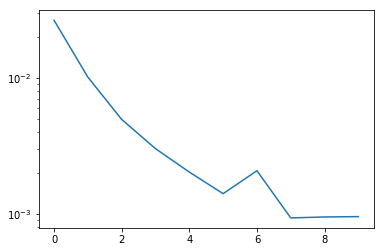

In [46]:
# plot train loss
plt.semilogy(train_losses)


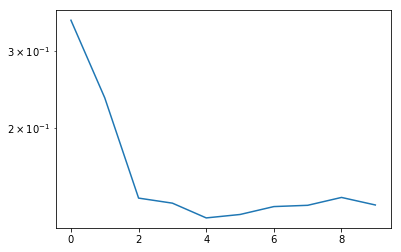

In [47]:
# plot validation loss
plt.semilogy(val_losses);

In [51]:
#test on the test set
val(model, device, test_loader)

Val set: Average loss: 0.1376, Accuracy: 434/456 (95%)



(0.13756760372371787, 95.17543859649123)

In [ ]:
# plot the confusion matrix
preds,targets = get_all_preds(model, test_loader,device)
cm = confusion_matrix(targets,preds.argmax(dim = 1))
plot_confusion_matrix(cm,['unmasked','masked','incorrectly_masked'],normalize = False,)

In [49]:
torch.save(model, 'model.pth')


ModuleNotFoundError: No module named 'google.colab'